<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest Regression 
</p>

In [1]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import PredefinedSplit, learning_curve
from scipy.stats import linregress

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [2]:
# Path to the standardized database directory
base_path = '../../Comprehensive ML - Files & Plots etc'

# Load train and test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

# (Should we need them for plotting)
time_train = df_train['time'].values
time_test = df_test['time'].values

# Load 5-fold assignments
fold_assignments = np.load(f"{base_path}/train_folds.npy")

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))
print('\nDataset loaded successfully!\n')


Training samples: 1663627, Test samples: 415907
{0: 332726, 1: 332726, 2: 332725, 3: 332725, 4: 332725}

Dataset loaded successfully!



<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Bayesian Search Space and Model Helper
</p>

In [3]:
# Our param space for Bayesian optimization
search_spaces = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(3, 9),  # Keep bounded; higher risks noise in large data
    'min_samples_split': Integer(50, 200),  # Higher min to generalize, avoid splits on noise
    'min_samples_leaf': Integer(50, 1000),  # Widen upper for stronger regularization on M+ samples
    'max_samples': Real(0.6, 0.9),  # Fraction of data per tree; <1.0 reduces overfitting
    'min_impurity_decrease': Real(0.001, 0.1, prior='log-uniform')  # Stronger reg range
}

def create_rf_model():
    return RandomForestRegressor(
        criterion='squared_error',
        max_features='log2',
        random_state=50,
        n_jobs=-1,
        min_impurity_decrease=0.01,  # Keeps splits meaningful
        bootstrap=True,
        oob_score=True  # For OOB validation to monitor overfitting
    )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Bayesian SearchCV with Custom Folds & Analysis Per-Depth Results 
</p>

In [4]:
# ---- Setup for multi-metric scoring ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- Create  PredefinedSplit (already have fold_assignments) ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization, scoring on both RMSE and R² ----
bayes_cv = BayesSearchCV(
    estimator=create_rf_model(),  # function for RF config
    search_spaces=search_spaces,
    n_iter=20,  # or as desired
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # selects best by RMSE
    n_jobs=-1,
    cv=ps,
    random_state=42,
    verbose=2,
    n_points=1,  # Default = 1; can be adjusted for parallel if hardware allows
    optimizer_kwargs={'n_initial_points': 10, 'acq_func': 'gp_hedge'}  # More initial randoms; robust acquisition
)

# Suppress skopt UserWarnings about repeated evaluation of the same hyperparameter set
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')

print(f"Starting Bayesian optimization with {bayes_cv.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...")

# ---- Fit Bayesian optimizer on training data ----
bayes_cv.fit(X_train, y_train) 

print("Bayesian optimization complete. Extracting results...")

# ---- Pull all tried configs/results into a dataframe ----
bayes_results = pd.DataFrame(bayes_cv.cv_results_)

# ---- For each max_depth, track best results for plotting ----
cv_summary_per_depth = []
for max_depth in range(3, 10):
    mask = bayes_results['param_max_depth'] == max_depth
    df_depth = bayes_results[mask]
    if not df_depth.empty:
        # Find best (highest) mean_test_neg_root_mean_squared_error (less negative = better)
        idx = df_depth['mean_test_neg_root_mean_squared_error'].idxmax()
        best_row = df_depth.loc[idx]
        best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
        std_rmse = best_row['std_test_neg_root_mean_squared_error']
        best_cv_r2 = best_row['mean_test_r2']
        std_cv_r2 = best_row['std_test_r2']
        best_params = {k.split('param_')[1]: best_row[k] for k in bayes_results.columns if k.startswith('param_')}
        print(f"Best Params for max_depth={max_depth}: {best_params}")
        print(f"Best CV RMSE for max_depth={max_depth}: {best_rmse:.4f}")
        print(f"STD of CV RMSE for max_depth={max_depth}: {std_rmse:.4f}")
        print(f"Best CV R² for max_depth={max_depth}: {best_cv_r2:.4f}")
        print(f"STD of CV R² for max_depth={max_depth}: {std_cv_r2:.4f}")
        cv_summary_per_depth.append({
            'max_depth': max_depth,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_cv_r2,
            'std_cv_r2': std_cv_r2,
            'best_params': best_params
        })

cv_df = pd.DataFrame(cv_summary_per_depth)

Starting Bayesian optimization with 20 iterations and 5-fold cross-validation per candidate...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples_split=151, n_estimators=183; total time=  59.7s
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples_split=151, n_estimators=183; total time= 1.0min
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples_split=151, n_estimators=183; total time= 1.0min
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples_split=151, n_estimators=183; total time= 1.0min
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples

/home/nahshon/envs/ml001/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=7, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=158, n_estimators=300; total time= 4.3min
[CV] END max_depth=7, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=158, n_estimators=300; total time= 4.4min
[CV] END max_depth=7, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=158, n_estimators=300; total time= 4.5min
[CV] END max_depth=7, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=158, n_estimators=300; total time= 4.6min
[CV] END max_depth=7, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=158, n_estimators=300; total time= 4.7min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=9, max_samples=0.6, min_impurity_decrease=0.001, min_samples_leaf=50, min_samples_split=200, n_estimators=300; total time= 3.5min
[CV] END max_depth=9, max_samples=0.6, min_impu

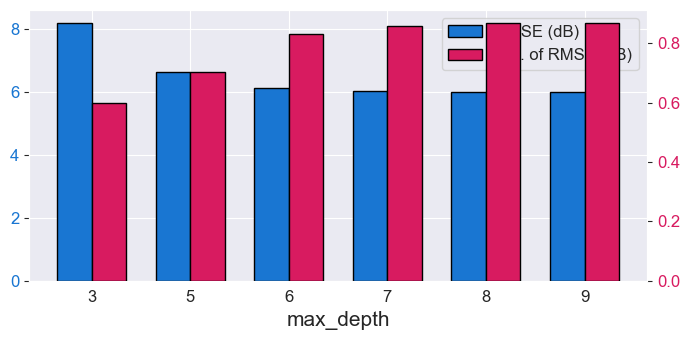

In [5]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax1.set_ylabel('RMSE (dB)', color='#1976d2', fontsize=axis_labelsize)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis), offset to right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax2.set_ylabel('Std. of RMSE (dB)', color='#d81b60', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestRMSE_&_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

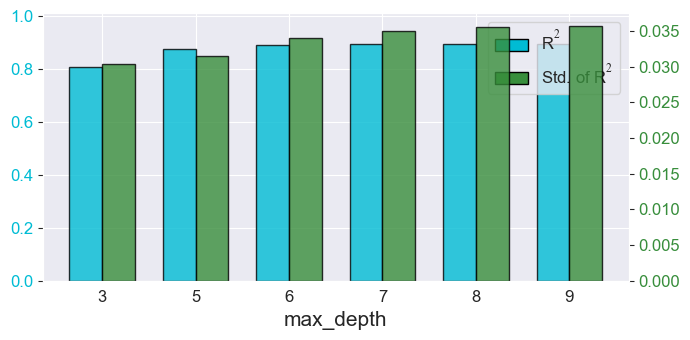

In [6]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# --- Cyan bars: Best CV R² (left y-axis) ---
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',                # Cyan
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
#ax1.set_ylabel('Best CV R$^2$', color='#00bcd4', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# --- Green bars: STD of CV R² (right y-axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',                # Green
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
#ax2.set_ylabel('Std. of CV R$^2$', color='#388e3c', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# --- Combined Legend (top right, inside) ---
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
#plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestR2_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [7]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_model = bayes_cv.best_estimator_
best_params = bayes_cv.best_params_
print("Best Parameters Found:", best_params)

print("\nUsing best model from BayesSearchCV (already trained on all data)...")

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

Best Parameters Found: OrderedDict({'max_depth': 8, 'max_samples': 0.6, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 50, 'min_samples_split': 145, 'n_estimators': 300})

Using best model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),24.646834
1,Test Loss (MSE),26.357706
2,Test RMSE,5.133976
3,R² Score (Train),0.930382
4,R² Score (Test),0.925650
5,Test MAPE (%),4.473659
6,Test Median AE,3.207835


In [8]:
# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the trained Random Forest model
with open('../Models/rf_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Trained Random Forest model saved to Models/rf_final_model.pkl")

Trained Random Forest model saved to Models/rf_final_model.pkl


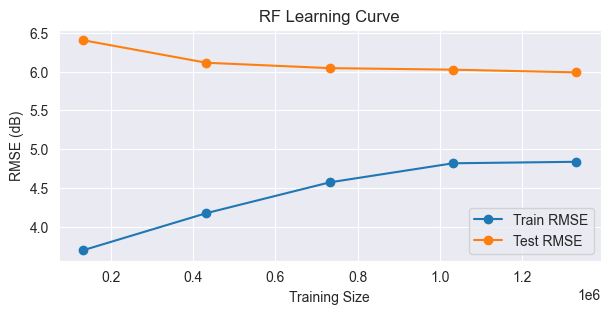

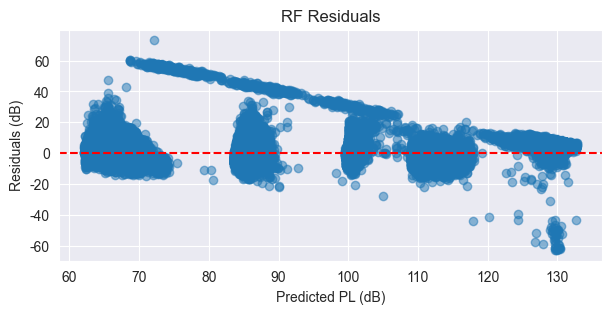

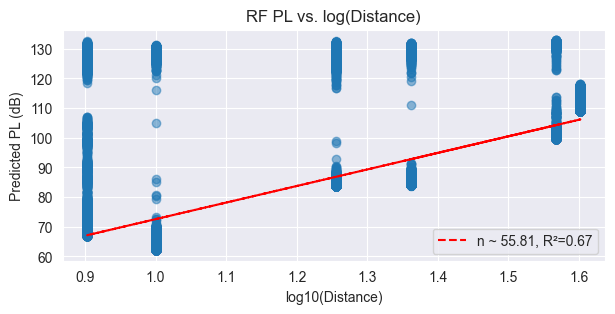

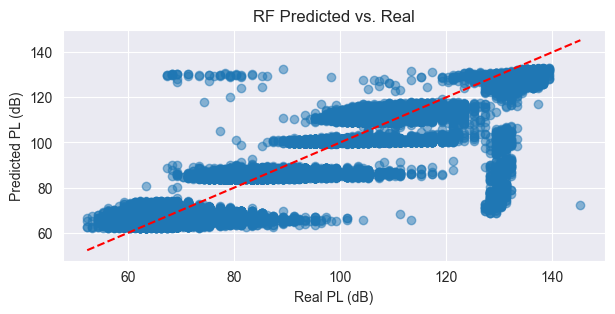

In [9]:
rf_model = best_model  # Already available

figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_root_mean_squared_error')
train_rmse = -train_scores.mean(1)
test_rmse = -test_scores.mean(1)
plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('RF Learning Curve')
plt.legend()
#plt.savefig(f'{path}RF_learning_curve.png', dpi=300)
plt.show()

# 2. Residuals
y_test_pred = rf_model.predict(X_test)
residuals = y_test - y_test_pred
plt.figure(figsize=figsize)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('RF Residuals')
#plt.savefig(f'{path}RF_residuals.png', dpi=300)
plt.show()

# 3. Physics Consistency (PL vs. log(distance))
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)
slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
plt.figure(figsize=figsize)
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('RF PL vs. log(Distance)')
plt.legend()
#plt.savefig(f'{path}RF_physics_consistency.png', dpi=300)
plt.show()

# 4. Predicted vs. Real
plt.figure(figsize=figsize)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('RF Predicted vs. Real')
#plt.savefig(f'{path}RF_pred_vs_real.png', dpi=300)
plt.show()